# Computational model figure

In [1]:
import os
import sys
import daft
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from optlearner import ProbabilityLearner

In [3]:
sns.set(style="white", context="paper",
        rc={"ytick.major.pad": 4,
            "xtick.major.pad": 4,
            "axes.labelsize": 8})

In [4]:
%matplotlib inline
mpl.rc("savefig", dpi=150)

In [5]:
def savefig(fig, name):
    fig.savefig("figures/{}.pdf".format(name), dpi=120)
    fig.savefig("figures/{}.png".format(name), dpi=120)
    fig.savefig("tiffs/{}.tiff".format(name), dpi=300)

In [6]:
design = pd.read_csv("data/scan_design.csv")

In [7]:
learner = ProbabilityLearner()

The learner was fit on the 100 in-scanner practice trials that were randomly generated and differnet for each participant. This means the learner is in a slightly differnet state for each participant, but those differences are small and dissapear very quickly. We'll just simulate a training run and fit the learner to that before fitting it to the scan design.

In [8]:
simulator = np.random.RandomState(45)
training = simulator.randint(0, 2, 100)
learner.fit(training)

Now fit the learner to the actual scan design

In [9]:
learner.fit(design.context)
p_hats = learner.p_hats[100:]

---

In [10]:
def bayes_net():
    
    # Initialize the graph object
    gray = ".3"
    gridshape = 3.5, 5.25
    pgm = daft.PGM(gridshape, node_ec=gray, grid_unit=2.54)
    scale = 1

    # Set up the grid for the i nodes
    xgrid = (np.linspace(0, gridshape[0], 7) + .3 )
    xs = xgrid[[0, 1, 2, -3, -2]]
    subscripts = ["1", "2", "3", "i-1", "i"]
    kws = {"plot_params": {"ec": gray, "fc": gray}}

    # Set up the y positions
    ys = dict(c=3.6, b=4.3, s=5)

    # Add the s node
    pgm.add_node(daft.Node("s", r"$s$", 1.75, ys["s"], scale))

    # Loop over each of the i positions
    for x, sub in zip(xs, subscripts):

        # Add a c_i node at this position
        c_node = "c" + sub
        pgm.add_node(daft.Node(c_node, r"$c_{" + sub + "}$", x, ys["c"],
                               scale, observed=True))

        # Add a b_i node at this position
        b_node = "b" + sub
        pgm.add_node(daft.Node(b_node, r"$b_{" + sub + "}$", x, ys["b"],
                               scale, plot_params={"facecolor": "w"}))

        # Connect the b and c nodes at each position
        pgm.add_edge(b_node, c_node, **kws)

        # Connect the b nodes to the s node
        b_node = "b" + sub
        pgm.add_edge("s", b_node, **kws)

    # Connect the b_i nodes to each other
    for sub_from, sub_to in zip(subscripts[:-1], subscripts[1:]):
        pgm.add_edge("b" + sub_from, "b" + sub_to, **kws)

    # Draw the graph so far
    ax = pgm.render()

    # Add ellipses and a blocker to divide 1, 2, 3 from i-1 and i
    kws = dict(size=30, ha="center", va="center", color=gray)
    ellipsis_x = xgrid[3] * 2.54
    ax.add_artist(plt.Rectangle((ellipsis_x - .5, (ys["b"] * 2.54) - .5), 1, 1,
                                facecolor="w", edgecolor="w"))
    for y in ys["b"], ys["c"]:
        ax.text(ellipsis_x, y * 2.54, "$" + "\cdot " * 3 + "$", **kws)

    # Set the size and shape of the node names
    for text in ax.texts:
        text.set_color(gray)
        text.set_size(10)

    return ax.figure

In [11]:
def hat_timeseries(ax):

    # Plot the generating frequency
    ax.plot(1 - design.color_freq, ls=":", color=".3", lw=1,
            dashes=[.75, 1.5], label="generating frequency")

    # Plot the posterior mean from the Bayesian model
    ax.plot(learner.p_hats[100:], color=".25", lw=.6, label="model estimate")

    # Add a legend
    ax.legend(loc="lower left", bbox_to_anchor=[.025, -.32, 1, 1], fontsize=8)

    # Set the supporting plot details
    ax.set_ylabel("p(color trial)", labelpad=1)
    ax.set(xlim=(-10, 900), ylim=(0, 1),
           xticks=[], yticks=[0, 1])
    sns.despine(ax=ax, bottom=True)

In [12]:
def hat_slice(ax):

    # Plot the estimated color trial probability
    start, stop = 570, 585
    slicer = slice(start - 1, stop)
    x = np.arange(start - 1, stop)
    y_p = p_hats[slicer]
    ax.plot(x, y_p, "o-", ms=3, lw=1, c=".25")

    # Plot the actual context values
    color = design.context[slicer].map({0: ".15", 1: ".5"})
    y_c = design.context[slicer]
    ax.scatter(x, y_c, color=color, s=10)

    # Plot the prediction error
    for x_i, y_p_i, y_c_i in zip(x, y_p, y_c):
        ax.plot((x_i, x_i), (y_p_i, y_c_i), ":", c=".25",
                lw=.8, dashes=[.8, .8], zorder=0)

    # Set other plot values
    ax.set_ylabel("p(color trial)", labelpad=1)
    ax.set(xlim=(start - 1.5, stop), ylim=(-.05, 1.05),
           xticks=[], yticks=[0, 1])
    ax.set_yticklabels(["0", "1"], ha="center")
    sns.despine(ax=ax, bottom=True)

In [13]:
def pe_slice(ax):

    # Plot the sliced timeseries of prediction errors
    start, stop = 570, 585
    slicer = slice(start - 1, stop)
    pe = np.where(design.context, 1 - p_hats, p_hats)
    x = np.arange(start - 1, stop)
    y_p = pe[slicer]
    ax.plot(x, y_p, "o-", ms=3, lw=1, c=".25")

    # Plot the actual context values
    color = design.context[slicer].map({0: ".15", 1: ".5"})
    y_c = np.zeros(stop - start + 1)
    ax.scatter(x, y_c, color=color, s=10)

    # Plot vertical bars showing the prediction error
    for x_i, y_p_i, y_c_i in zip(x, y_p, y_c):
        ax.plot((x_i, x_i), (y_p_i, y_c_i), ":", c=".25",
                lw=.8, dashes=[.8, .8], zorder=0)

    # Set other plot values
    ax.set_ylabel("context\nprediction error", labelpad=2)
    ax.set(xlim=(start - 1.5, stop), ylim=(-.05, 1.05),
           xticks=[], yticks=[0, 1])
    ax.set_yticklabels(["0", "1"], ha="center")
    sns.despine(ax=ax, bottom=True)

In [14]:
def pe_timeseries(ax):
    
    # Plot the full timeseries of prediction errors
    pe = np.where(design.context, 1 - p_hats, p_hats)    
    ax.plot(pe, color=".25", lw=.6)

    # Set the supporting plot details
    ax.set_ylabel("context\nprediction error", labelpad=1)
    ax.set(xlim=(-10, 900), ylim=(0, 1),
           xticks=[], yticks=[0, 1])
    ax.set_yticklabels(["0", "1"], ha="center")
    sns.despine(ax=ax, bottom=True)

----

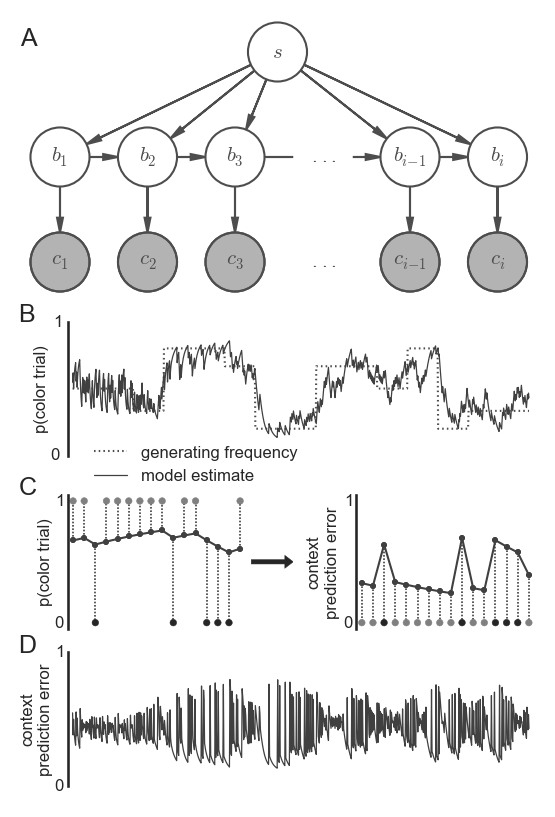

In [15]:
fig = bayes_net()

hat_ax = fig.add_axes([.1, .44, .88, .17])
hat_timeseries(hat_ax)

pe_ax1 = fig.add_axes([.1, .22, .35, .17])
hat_slice(pe_ax1)

pe_ax2 = fig.add_axes([.65, .22, .35, .17])
pe_slice(pe_ax2)

arrow_ax = fig.add_axes([.45, .22, .08, .17])
arrow_ax.set_axis_off()
arrow_ax.add_artist(plt.Arrow(0, .5, 1, 0, .16, color=".15"))

pe_ax3 = fig.add_axes([.1, .02, .88, .17])
pe_timeseries(pe_ax3)

fig.text(.01, .96, "A", size=12)
fig.text(.01, .61, "B", size=12)
fig.text(.01, .39, "C", size=12)
fig.text(.01, .19, "D", size=12)

savefig(fig, "computational_model")

----

In [16]:
mpl.rc("savefig", dpi=100)
sns.set_context({"axes.labelsize": 12})
sns.set_style({"axes.linewidth": .85})
model_color = "#3a4b71"
model_cmap = sns.cubehelix_palette(as_cmap=True, start=0, rot=-.2, light=1)

In [17]:
def joint_dist(axes, learner):

    # Plot the joint distribution with color-encoded density
    # Drawing the contour lines under the fill helps it look better in pdf
    axes[0].contour(learner.I_grid, learner.p_grid, learner.pI, 50,
                    cmap=model_cmap, vmin=0, vmax=0.003)
    axes[0].contourf(learner.I_grid, learner.p_grid, learner.pI, 50,
                     cmap=model_cmap, vmin=0, vmax=0.003)

    # Plot the marginal distributions
    axes[1].plot(learner.I_grid, learner.I_dists[-1], c=model_color)
    axes[2].plot(learner.p_dists[-1], learner.p_grid, c=model_color)

    # Use hardcoded values to set the plot ranges
    plim = learner.p_grid.min(), learner.p_grid.max()
    Ilim = learner.I_grid.min(), learner.I_grid.max()
    
    axes[0].set(xlim=Ilim, ylim=plim)
    axes[1].set(xticks=[], yticks=[], xlim=Ilim, ylim=(0, .1))
    axes[2].set(xticks=[], yticks=[], ylim=plim, xlim=(0, .05))
    
    sns.despine(ax=axes[1], left=True)
    sns.despine(ax=axes[2], bottom=True)


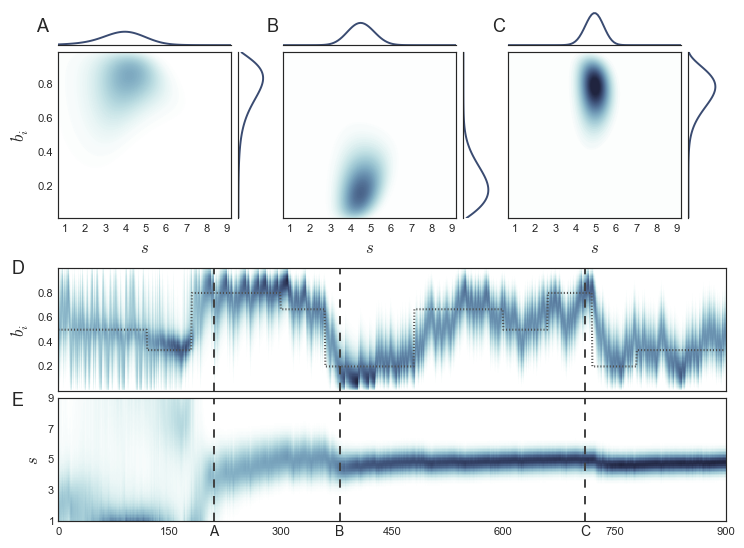

In [18]:
f = plt.figure(figsize=(7.5, 5.5))

gs = plt.GridSpec(12, 15)

learner.reset()
training = np.random.RandomState(45).randint(0, 2.7, 100)
learner.fit(training)

slices = [210, 380, 710]

xvar, yvar = "$s$", "$b_i$"

# -----------------------------------------------------------------------

learner.fit(design.context.iloc[:slices[0]])

axes = (f.add_subplot(gs[1:5, 0:4]),
        f.add_subplot(gs[0,   0:4]),
        f.add_subplot(gs[1:5, 4]))
joint_dist(axes, learner)
axes[0].set(xlabel=xvar, ylabel=yvar)

# -----------------------------------------------------------------------

learner.fit(design.context.iloc[slices[0]:slices[1]])

axes = (f.add_subplot(gs[1:5, 5:9]),
        f.add_subplot(gs[0,   5:9]),
        f.add_subplot(gs[1:5, 9]))
joint_dist(axes, learner)
axes[0].set(yticks=[], xlabel=xvar)

# -----------------------------------------------------------------------

learner.fit(design.context.iloc[slices[1]:slices[2]])

axes = (f.add_subplot(gs[1:5, 10:14]),
        f.add_subplot(gs[0,   10:14]),
        f.add_subplot(gs[1:5, 14]))
joint_dist(axes, learner)
axes[0].set(yticks=[], xlabel=xvar)

# =======================================================================

line_kws = dict(c=model_color, lw=1)

learner.fit(design.context.iloc[slices[2]:])

ax_b = f.add_subplot(gs[6:9, :])
b_x, b_y = np.meshgrid(np.arange(900), learner.p_grid)
ax_b.pcolormesh(b_x, b_y, np.column_stack(learner.p_dists[100:]),
                cmap=model_cmap, rasterized=True)
ax_b.plot(1 - design.color_freq, c=".3", lw=1.5, dashes=[.75, 1.5])
ax_b.set(xticks=[], yticks=[.2, .4, .6, .8], ylabel=r"$b_i$")

# -----------------------------------------------------------------------

ax_s = f.add_subplot(gs[-3:, :])
s_x, s_y = np.meshgrid(np.arange(900), learner.I_grid)
ax_s.pcolormesh(s_x, s_y, np.column_stack(learner.I_dists[100:]),
                cmap=model_cmap, rasterized=True)
ax_s.set(xticks=[0, 150, 300, 450, 600, 750, 900],
         yticks=range(1, 10, 2), ylim=(1, 9), ylabel="$s$")

for x, letter in zip(slices, list("ABC")):
    for ax in [ax_b, ax_s]:
        ax.axvline(x, ls="--", c=".25", zorder=1)
    ax_s.text(x, .06, letter, size=10, ha="center")

# -----------------------------------------------------------------------

f.subplots_adjust(.08, .05, .97, .98)
f.text(.05, .94, "A", size=13)
f.text(.36, .94, "B", size=13)
f.text(.66, .94, "C", size=13)
f.text(.02, .50, "D", size=13)
f.text(.02, .26, "E", size=13)

savefig(f, "model_supplement")